## Load in the data and have it ready for use

In [306]:
import pandas as pd
import numpy as np
from pathlib import Path

data = Path("./data/M3_2nights_rawPhotometry.csv")
df = pd.read_csv(data, usecols=("Name  ", "Mag   ", "Error ", "JD"))
df.columns = [x.strip() for x in df.columns]
df["Mag"] = pd.to_numeric(df["Mag"], errors="coerce")
df["Error"] = pd.to_numeric(df["Error"], errors="coerce")
df["Time"] = pd.to_datetime(df["JD"], unit='D', origin='julian')
df["JD"] = pd.to_numeric(df["JD"], errors="coerce")
df = df.set_index("Time")

## Fix any issues with the data

In [309]:
df = df.dropna(how="all")
df = df.drop_duplicates()
# Remove any entries without the most common number of datapoints
mode = df.groupby("Name").count().mode().values[0]
counted = df.groupby("Name").count()
good_stars = counted[(counted == mode).all(1)].index.values
df = df[df["Name"].isin(good_stars)]

## Differential Photometry and error propagation

In [310]:
def diff_phot(star, df):
    other_stars = df[df["Name"] != star.name]
    star_mag = star["Mag"].values
    other_mags = other_stars["Mag"].values
    star_error = star["Error"].values
    other_errors = other_stars["Error"].values
    N = len(other_mags) + 1
    num_stars = other_stars["Name"].nunique()
    rows = other_stars.shape[0]
    samples = int(rows / num_stars)
    shape = (samples, num_stars)
    other_mags = other_mags.reshape(shape).transpose()
    other_errors = other_errors.reshape(shape).transpose()
    star["DMag"] = np.mean((other_mags - star_mag), axis=0).ravel()
    star["DError"] = np.sqrt(np.sum(other_errors**2 + star_error**2, axis=0))/N
    return star
    

df = df.groupby("Name").apply(diff_phot, df)

In [227]:
def w_avg(df, values, weights):
    d = df[values]
    w = df[weights]
    return (d * w).sum() / w.sum()

## Exploratory data analysis

Name       M3-4M3-4M3-4M3-4M3-4M3-4M3-4M3-4M3-4M3-4M3-4M3...
Mag                                                1598.2931
Error                                                27.1474
JD                                          258232144.930995
DMag                                             -144.830592
DError                                              0.012102
DAvg                                              -151.73825
DMedian                                          -132.853321
DResid                                            -11.977271
dtype: object

<Figure size 864x576 with 0 Axes>

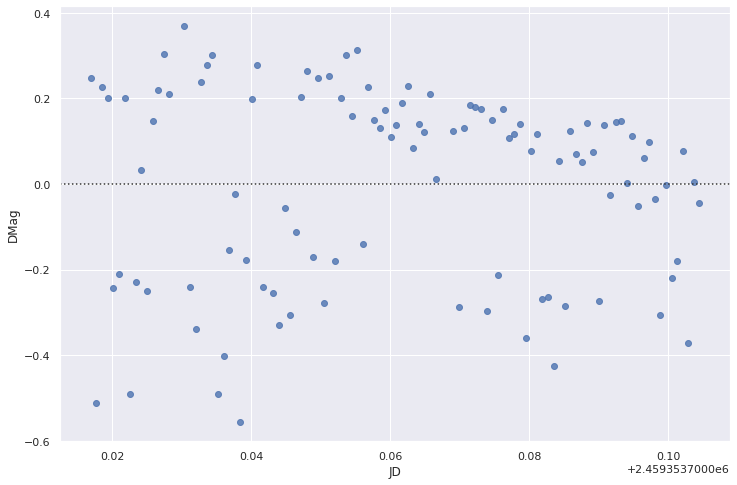

In [357]:
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
sns.set_theme(style="darkgrid")
fig1 = plt.figure(figsize=(12,8))
fig2 = plt.figure(figsize=(12,8))
star_name = "M3-4"
star = df[(df["Name"] == star_name) & (df.index.day == 19)].copy()
star["DAvg"] = w_avg(star, "DMag", "DError")
star["DMedian"] = star["DMag"].median()
star["DResid"] = star["DMag"] - star["DMedian"]
#model = ols('DMedian ~ DMag', data=star).fit()
#sns.scatterplot(data=star, x="Time", y="DResid", ax=fig1.gca())
#sm.graphics.plot_regress_exog(model, 'DMag', fig=fig2)
sns.pairplot(star, x_vars=["JD", "DError", "DMag", "DResid"], y_vars=["DMag", "DResid", "DError"], height=8)
sns.residplot(data=star, x="JD", y="DMag")
star.sum()

In [330]:
df

,Name,Mag,Error,JD,DMag,DError
Time,,,,,,
2021-05-19 05:12:20.998086400,M3-1,13.3685,0.0447,2.459354e+06,0.515201,0.000053
2021-05-19 05:12:20.998086400,M3-10,14.6658,0.0419,2.459354e+06,-0.788050,0.000053
2021-05-19 05:12:20.998086400,M3-100,13.5764,0.0594,2.459354e+06,0.306348,0.000055
2021-05-19 05:12:20.998086400,M3-101,13.8047,0.0258,2.459354e+06,0.077000,0.000051
2021-05-19 05:12:20.998086400,M3-102,15.0523,0.0365,2.459354e+06,-1.176322,0.000052
...,...,...,...,...,...,...
2021-05-29 06:57:14.996174336,M3-95,13.2968,0.0402,2.459364e+06,0.524198,0.000048
2021-05-29 06:57:14.996174336,M3-96,14.3389,0.0651,2.459364e+06,-0.522683,0.000053
2021-05-29 06:57:14.996174336,M3-97,15.2248,0.0458,2.459364e+06,-1.412646,0.000049
